# Project description

Data for this project consists of two tables in a tab-separated columns format. Each row in those files corresponds to an abstract of a scientific article from ACM Digital Library, which was assigned to one or more topics from the ACM Computing Classification System.

The training data (DM2020_training_docs_and_labels.csv) has three columns: the first one is an identifier of a document, the second one stores the text of the abstract, and the third one contains a list of comma-separated topic labels.

The test data (DM2020_test_docs.csv) has a similar format, but the labels in the third column are missing.

The task and the format of submissions: the task for you is to predict the labels of documents from the test data and submit them to the evaluation system. A correctly formatted submission should be a text file with exactly 100000 lines. Each line should correspond to a document from the test data set (the order matters!) and contain a list of one or more predicted labels, separated by commas.

Evaluation: the quality of submissions will be evaluated using the average F1-score measure, i.e., for each test document, the F1-score between the predicted and true labels will be computed, and the values obtained for all test cases will be averaged.

# Solution

## Loading data

Let's load the training set.

Our texts have multiple labels, so we will use one hot encoding.

In [1]:
import csv

import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer


def load_training_data(filepath):
    with open(filepath, 'rb') as f:
        decoded_lines = (line.decode(encoding='iso_8859_1') for line in f)
        parsed_lines = csv.reader(decoded_lines, dialect="excel-tab")

        names = []
        texts = []
        label_lists = []
        
        for name, text, labels in parsed_lines:
            names.append(name)
            texts.append(text)
            
            labels = labels.split(',')
            label_lists.append(labels)
    
    mlb = MultiLabelBinarizer()
    df_labels = pd.DataFrame(mlb.fit_transform(label_lists), columns=mlb.classes_)
    
    df = pd.DataFrame({'name': names, 'text': texts})
    return pd.concat((df, df_labels), axis=1)


df = load_training_data('data/DM2020_training_docs_and_labels.txt')
labels = df.columns[2:]

## Label distribution

Firstly, let's look into label distribution. We can plot frequency of each label:

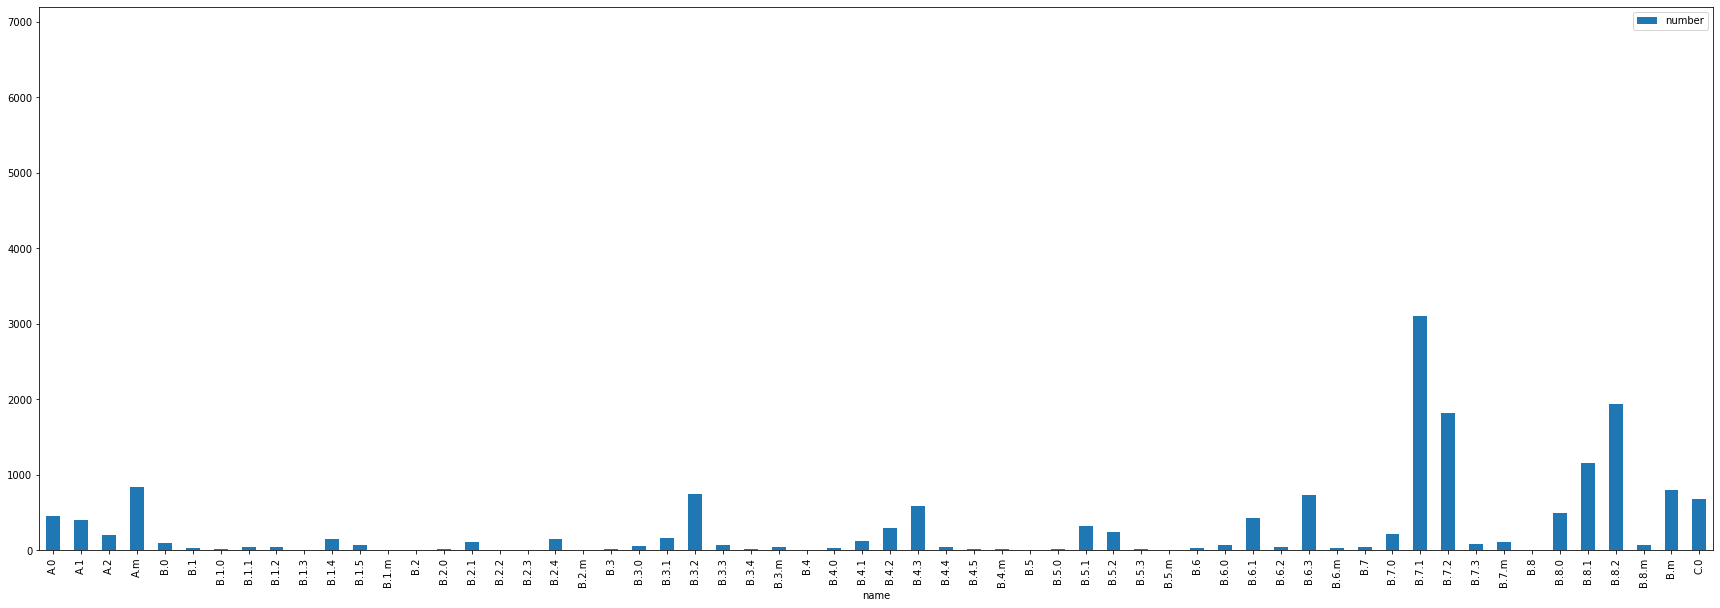

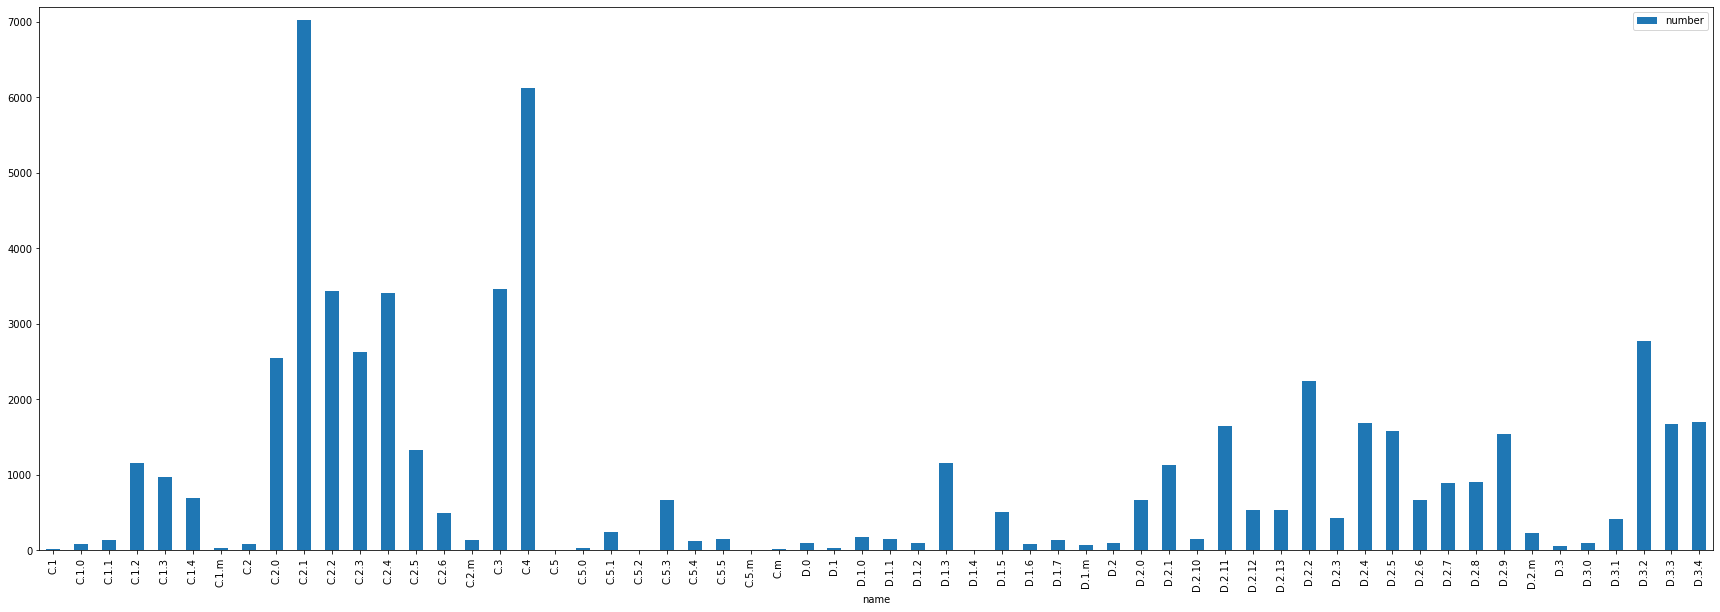

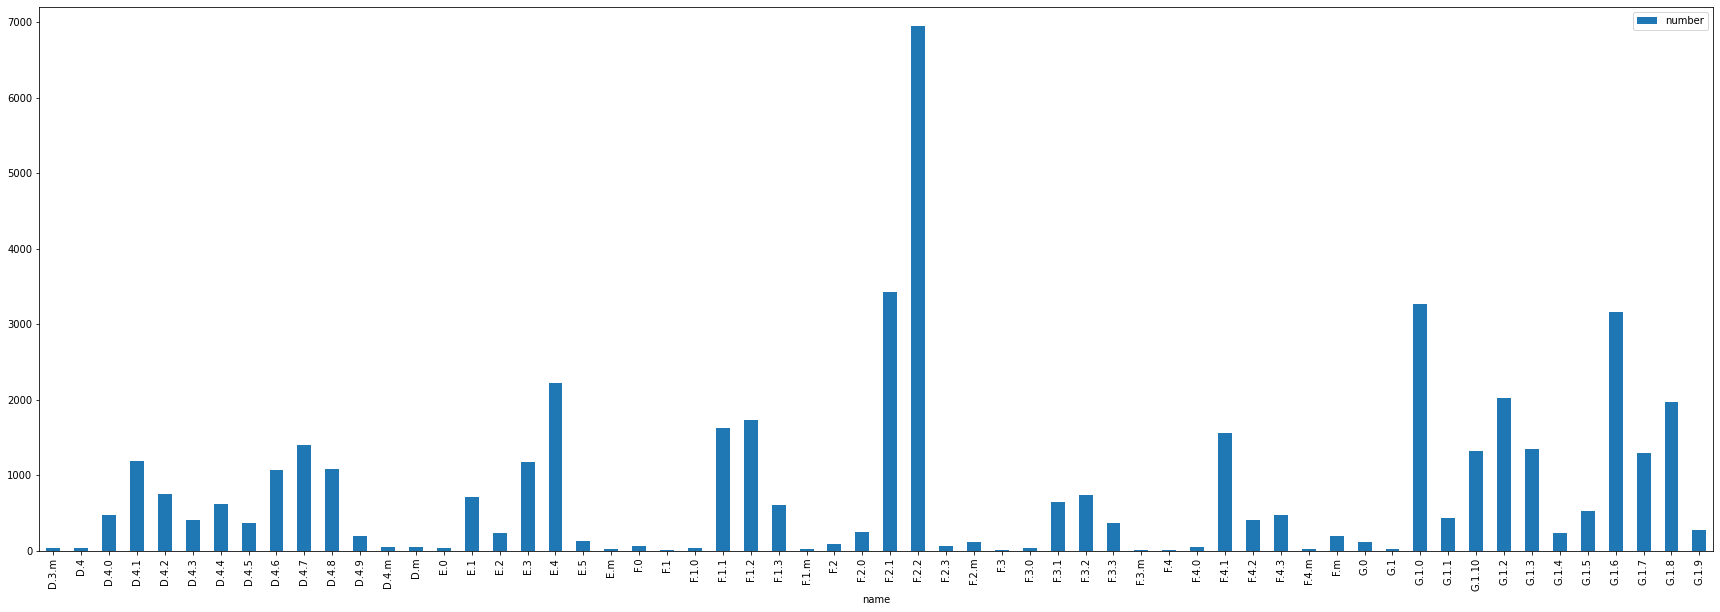

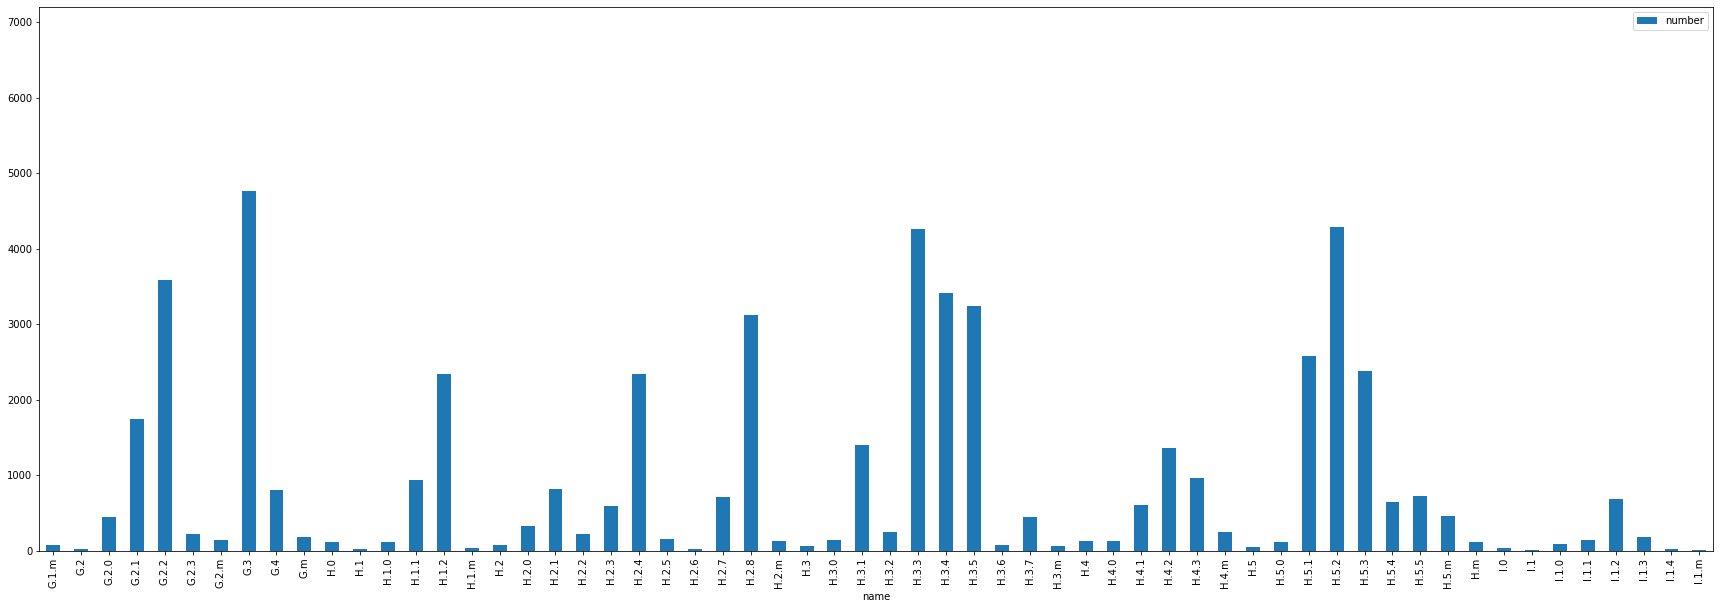

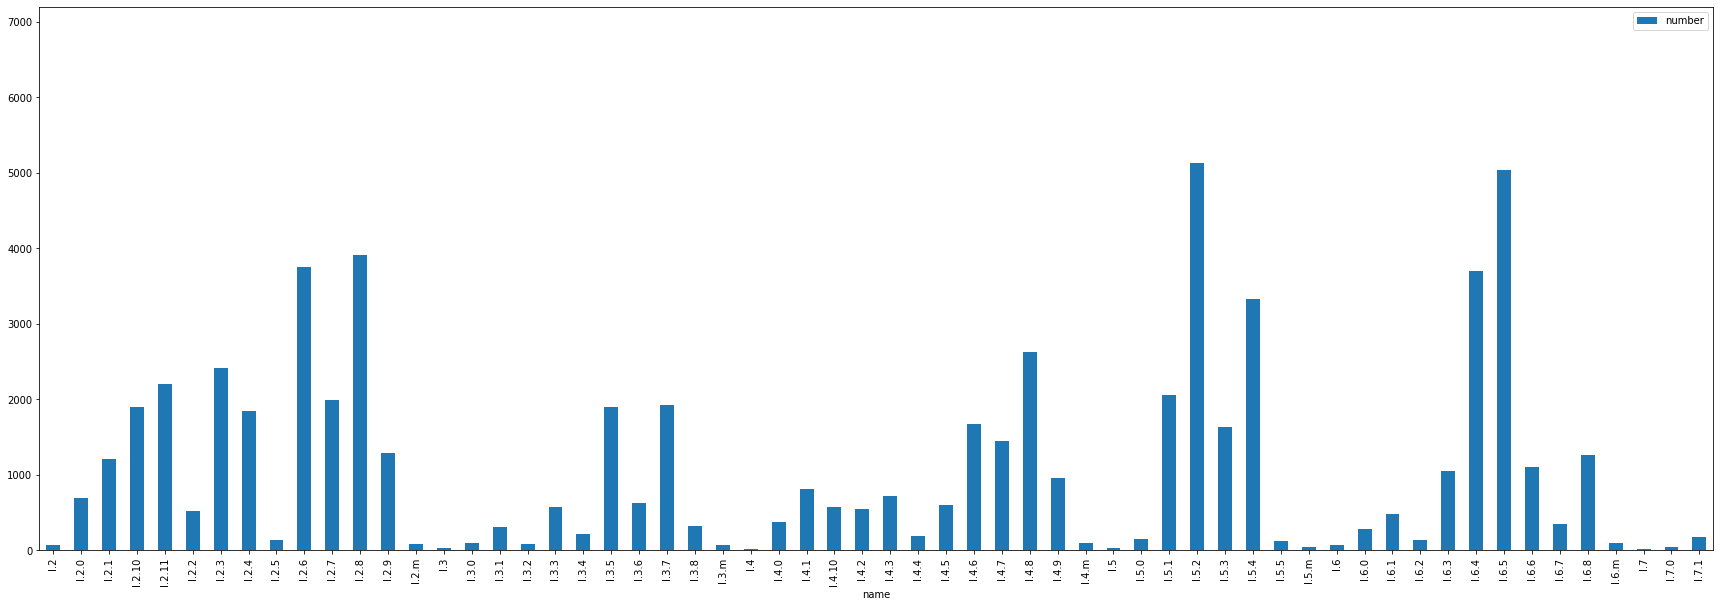

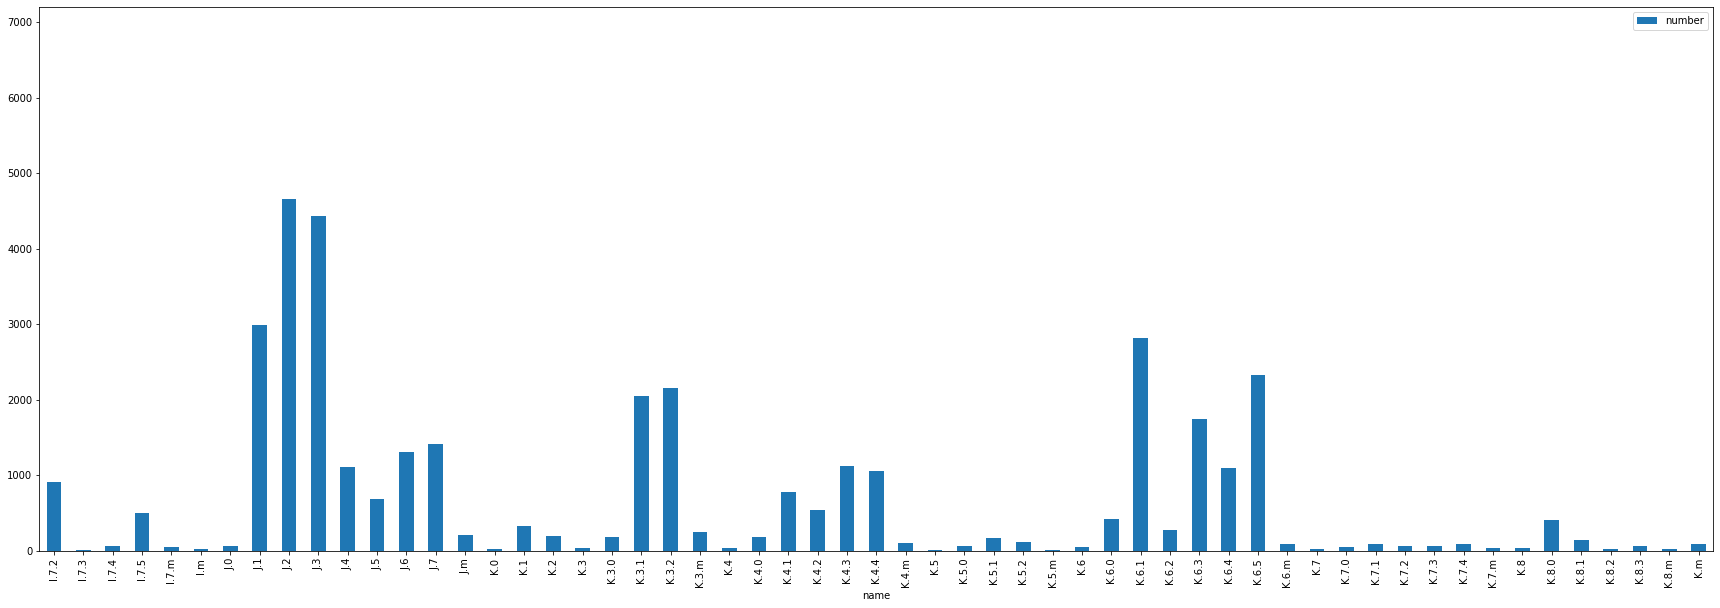

In [2]:
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [30,10]

sums = [sum(df[label]) for label in labels]
df_sum = pd.DataFrame({'name': labels, 'number': sums})
interval = 60

for a, b in zip(range(0, len(labels), interval), range(interval, len(labels) + interval, interval)):
    df_sum[a:b].plot.bar(x='name', ylim=(0, 7200))

Most frequent labels:

In [3]:
df_sum.sort_values(by='number', ascending=False).head(20)

,name,number
69,C.2.1,7030
151,F.2.2,6946
77,C.4,6125
281,I.5.2,5125
292,I.6.5,5035
187,G.3,4767
308,J.2,4658
309,J.3,4437
226,H.5.2,4288
211,H.3.3,4256


Least frequent labels:

In [4]:
df_sum.sort_values(by='number', ascending=True).head(20)

,name,number
159,F.3.m,3
12,B.1.m,3
301,I.7.3,4
160,F.4,4
40,B.5.m,5
35,B.5,5
154,F.3,5
13,B.2,5
142,F.1,5
239,I.1.m,7


We see that there is only one case of class "J" (Computer Applications). We correct it to "J.0" (Computer Applications - GENERAL) and reload the dataset.

## Text cleanup

Our texts are a little bit "dirty" - they need some cleaning before we can feed them to classificators.

We observe that some texts have unwanted characters (`"<U+00BF>"`) that are probably a result of problems with encoding at some stage of data acquisition. We will get rid of them with regex and remove all markup using `BeautifulSoup`.

The texts are in english and have some english abbreviations, e.g "what's" - we will take care of them as well.

Last but not least - we have to strip the texts with all whitespace and replace it with spaces and replace uppercase letters with lowercase letters.

In [5]:
import re
from bs4 import BeautifulSoup


def clean_text(text: str):
    text = re.sub(r"<U\+00F\S>", "", text)
    text = re.sub(r"<U\+00\S\S>", " ", text)
    text = BeautifulSoup(text, features="html.parser").get_text()
    
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "can not ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub('\W', ' ', text)
    text = re.sub('\s+', ' ', text)
    text = text.strip(' ')
    return text

print('Before cleaning:\n{}\n'.format(df['text'][0]))
df['text'] = df['text'].apply(clean_text)
print('After cleaning:\n{}'.format(df['text'][0]))

Before cleaning:
None Responding to marketplace needs, today's embedded processors must feature a flexible core that allows easy modification with fast time to market. In this environment, embedded processors are increasingly reliant on flexible support tools. This paper presents one such tool, called Quick Piping, a new, high-level formalism for modeling processor pipelines. Quick Piping consists of three primary components that together provide an easy-to-build, reus<U+00BF>able processor description: Pipeline graphs-a new high-level formalism for model<U+00BF>ing processor pipelines,pipe--a companion domain-specific language for specify<U+00BF>ing a pipeline graph, pipe miner--a compiler specification generator for pipe descriptions. pipe miner processes a pipe description and produces a compiler specification that is used to build a compiler that reads the corresponding machine's instruc<U+00BF>tion set and automatically generates resource vectors.Despite their ubiquity and importa

## Classificators

We will check 3 classification models:
* **Naive Bayes**
* **Linear SVC**
* **Logistic Regression**


The models do not support multi-target classification, so we have to fit and predict each label at a time. We use `OneVsRestClassifier` for that.

We need to convert our texts to a format that can be accepted by classifiers. One of the possible formats is **td-idf** (term frequency–inverse document frequency), which reflects how important a word is to a document in a collection or corpus.

In [6]:
from sklearn.feature_extraction.text import (
    ENGLISH_STOP_WORDS,
    TfidfVectorizer,
)

import nltk
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC


STOP_WORDS = set(stopwords.words('english')).update(ENGLISH_STOP_WORDS)


def get_naive_bayes_pipeline(n_jobs=-1):
    return Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word', stop_words=STOP_WORDS, min_df=2, max_df=0.9, strip_accents='unicode')),
        ('clf', OneVsRestClassifier(MultinomialNB(), n_jobs=n_jobs)),
    ])

def get_logistic_pipeline(C=1.0, solver='sag', max_iter=100, n_jobs=-1):
    return Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word', stop_words=STOP_WORDS, min_df=2, max_df=0.9, strip_accents='unicode')),
        ('clf', OneVsRestClassifier(LogisticRegression(C=C, solver=solver, max_iter=max_iter), n_jobs=n_jobs)),
    ])

def get_svm_pipeline(C=1.0, n_jobs=-1):
    return Pipeline([
        ('tfidf', TfidfVectorizer(analyzer='word', stop_words=STOP_WORDS, min_df=2, max_df=0.9, strip_accents='unicode')),
        ('clf', OneVsRestClassifier(LinearSVC(C=C), n_jobs=n_jobs)),
    ])

In [7]:
def fit_and_predict(pipeline, df_train, df_test, labels):
    predictions = pd.DataFrame(df_test['name'])
    
    for i, category in enumerate(labels):
        pipeline.fit(df_train['text'], df_train[category])
        pred = pipeline.predict(df_test['text'])
        predictions = predictions.assign(**{category: pred})
    
    return predictions

Before predicting labels for our task and submitting the result to a challange platform, we have to check which classifiers and tricks work best, so we split our training data into training data (75%) and test data (25%) and check our models.

In [8]:
from sklearn.model_selection import train_test_split


df_train, df_test = train_test_split(df, random_state=42, test_size=0.25, shuffle=True)

### Naive Bayes

In [9]:
pred_nb = fit_and_predict(get_naive_bayes_pipeline(), df_train, df_test, labels)

In [10]:
pred_nb.head()

,name,A.0,A.1,A.2,A.m,B.0,B.1,B.1.0,B.1.1,B.1.2,...,K.7.3,K.7.4,K.7.m,K.8,K.8.0,K.8.1,K.8.2,K.8.3,K.8.m,K.m
75721,1342625.txt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
80184,1381812.txt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
19864,336578.txt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
76699,1247849.txt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92991,570742.txt,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Our challange is to achieve the best possible **F1 score**, so we will care about it the most, but we will also calculate **precision** and **accuracy**, to see what is happening and to be able to tweak our models.

In [11]:
from sklearn.metrics import (
    f1_score,
    precision_score,
    recall_score,
)


def calculate_f1(predictions, df_test, labels):
    return f1_score(df_test.get(labels), predictions.get(labels), average='samples', zero_division=0)


def calculate_precision(predictions, df_test, labels):
    return precision_score(df_test.get(labels), predictions.get(labels), average='samples', zero_division=0)


def calculate_recall(predictions, df_test, labels):
    return recall_score(df_test.get(labels), predictions.get(labels), average='samples', zero_division=0)


def print_scores(predictions, df_test, labels):
    f1 = calculate_f1(predictions, df_test, labels)
    print(f'F1 score: {f1}')

    precision = calculate_precision(predictions, df_test, labels)
    print(f'Precision: {precision}')

    recall = calculate_recall(predictions, df_test, labels)
    print(f'Recall: {recall}')

In [12]:
print_scores(pred_nb, df_test, labels)

F1 score: 0.011645238095238094
Precision: 0.02001333333333333
Recall: 0.008970380952380952


As we can see, Naive Bayes doesn't do well.

### Linear SVC

In [13]:
pred_svc_c_1 = fit_and_predict(get_svm_pipeline(C=1.0), df_train, df_test, labels)
print_scores(pred_svc_c_1, df_test, labels)

F1 score: 0.2984154747474748
Precision: 0.4365833333333334
Recall: 0.2567800981240981


Linear SVC also has regularization parameter `C`. Let's check if increasing `C` improves performance.

The default is `1.0`. Let's check `5.0`.

In [14]:
pred_svc_c_5 = fit_and_predict(get_svm_pipeline(C=5.0), df_train, df_test, labels)
print_scores(pred_svc_c_5, df_test, labels)

F1 score: 0.3107845863025863
Precision: 0.40365934920634916
Recall: 0.29466466955266957


### Logistic regression

In [16]:
pred_logistic_c_1 = fit_and_predict(get_logistic_pipeline(C=1.0), df_train, df_test, labels)
print_scores(pred_logistic_c_1, df_test, labels)

F1 score: 0.2245212079032079
Precision: 0.3446484285714286
Recall: 0.1878690808080808


We will check how (and if) the regularization parameter (`C`) influences the result of Logistic Regression.

The default is `1.0`. Let's check `0.1` and `10.0`.

In [17]:
pred_logistic_c_01 = fit_and_predict(get_logistic_pipeline(C=0.1), df_train, df_test, labels)
print_scores(pred_logistic_c_01, df_test, labels)

F1 score: 0.050435142857142866
Precision: 0.08423333333333334
Recall: 0.039630904761904756


In [18]:
pred_logistic_c_10 = fit_and_predict(get_logistic_pipeline(C=10.0), df_train, df_test, labels)
print_scores(pred_logistic_c_10, df_test, labels)

F1 score: 0.29959420712620716
Precision: 0.4243862380952382
Recall: 0.2657165743145743


We can see that setting `C=10.0` improves all stats greatly. Let's check it for `C=20`!

In [19]:
pred_logistic_c_20 = fit_and_predict(get_logistic_pipeline(C=20.0), df_train, df_test, labels)
print_scores(pred_logistic_c_20, df_test, labels)

F1 score: 0.30456998712398714
Precision: 0.42108809523809526
Recall: 0.2750774314574314


We can see that recall increased but precision decreased, so we suppose that it won't improve on further parameter increase.

There is one more *clever* way of inreasing recall and decrease precision - decreasing the decision threshold:

In [20]:
def fit_and_predict_logistic(df_train, df_test, labels, C=1.0, threshold=0.5, n_jobs=-1):
    pipeline = get_logistic_pipeline(C=C, n_jobs=n_jobs)
    predictions = pd.DataFrame(df_test['name'])

    for i, category in enumerate(labels):
        pipeline.fit(df_train['text'], df_train[category])
        pred = (pipeline.predict_proba(df_test['text'])[:, 1] >= threshold).astype(int)
        predictions = predictions.assign(**{category: pred})

    return predictions

In [21]:
pred_logistic_c_1_t_015 = fit_and_predict_logistic(df_train, df_test, labels, C=1.0, threshold=0.15)
print_scores(pred_logistic_c_1_t_015, df_test, labels)

F1 score: 0.3985782013280837
Precision: 0.4314285452325452
Recall: 0.4550399422799423


After playing with multiple parameter configuration:

* `C = 1.0, threshold = 0.5`

```
F1 score: 0.22399187456987457
Precision: 0.34360509523809524
Recall: 0.18752174747474745
```

* `C = 1.0, threshold = 0.4`

```
F1 score: 0.2720341351981352
Precision: 0.3949718888888888
Recall: 0.2381718759018759
```

* `C = 1.0, threshold = 0.3`

```
F1 score: 0.32396974003774004
Precision: 0.4366673492063492
Recall: 0.30217359018759016
```

* `C = 1.0, threshold = 0.2`

```
F1 score: 0.37612265922965926
Precision: 0.4485183953823954
Recall: 0.3906865281385281
```

* **`C = 1.0, threshold = 0.15`**

```
F1 score: 0.39857453899042133
Precision: 0.43142635475635477
Recall: 0.4550319422799423
```

* **`C = 1.0, threshold = 0.1`**

```
F1 score: 0.4063851057473359
Precision: 0.38242067363029125
Recall: 0.5433441803751803
```

* `C = 1.0, threshold = 0.05`

```
F1 score: 0.35440506616835415
Precision: 0.26071897747888584
Recall: 0.6852806132756133
```

* `C = 10.0, threshold = 0.5`

```
F1 score: 0.299329197025197
Precision: 0.4241084285714285
Recall: 0.265616240981241
```

* `C = 10.0, threshold = 0.4`

```
F1 score: 0.33141764857364864
Precision: 0.4403473809523809
Recall: 0.30966100288600285
```

* `C = 10.0, threshold = 0.3`

```
F1 score: 0.36254445110445116
Precision: 0.4426806984126984
Recall: 0.36432986002886003
```

* `C = 10.0, threshold = 0.2`

```
F1 score: 0.3869891514890339
Precision: 0.41897179309579313
Recall: 0.434980101010101
```

* `C = 10.0, threshold = 0.1`

```
F1 score: 0.3861434005596265
Precision: 0.3424029859029859
Recall: 0.5458180072150073
```


## Combining results of multiple classificators

If we have more than one classifier that performs well, then we could try to merge their results.

If we have classifiers that have **high precision** and **low recall**, it means that they give labels accurately, but they don't give many labels. If we simply add labels for every text, we will *possibly* increase recall depending on how much the predictions overlap.

If we have classifiers that have **low precision** and **high recall**, the labels that are needed are generaly given, but there are too many labels given.. If we take intersection of labels for every text, we will strip those labels that are not returned by all classifiers and *maybe* increase the precision.

Our case is **high precision** and **low recall**.

In [23]:
def combine_predictions(preds, labels):
    res = preds[0].copy()
    
    for pred in preds[1:]:
        for label in labels:
            res[label] = res[label] | pred[label]
    
    return res

In [24]:
pred_combined = combine_predictions([pred_logistic_c_1_t_015, pred_svc_c_1], labels)
print_scores(pred_combined, df_test, labels)

F1 score: 0.4030546928365752
Precision: 0.43403316428016425
Recall: 0.46128337085137083


As we can see, it works!

## Filling empty lines

Even after merging results of multiple classifiers, some texts have no labels. One or more labels are required by the challenge rules, so we need to fill the empty lines. Filling them with most frequent label (or many labels) seems to be reasonable idea - we want to maximise the chance of hitting the right label.

Let's check how many labels gives the best result:

In [25]:
def fill_empty(predictions, default_labels: list):
    res = predictions.copy()
    
    for i, row in res.iterrows():
        if not row.get(labels).eq(1).any():
            for label in default_labels:
                res.at[i, label] = 1
    return res

In [26]:
print('Without filling:')
print_scores(pred_combined, df_test, labels)

pred_filled_1 = fill_empty(pred_combined, ['C.2.1'])
print('\nFilled with C.2.1:')
print_scores(pred_filled_1, df_test, labels)

pred_filled_2 = fill_empty(pred_combined, ['C.2.1', 'C.4'])
print('\nFilled with [C.2.1, C.4]:')
print_scores(pred_filled_2, df_test, labels)

pred_filled_3 = fill_empty(pred_combined, ['C.2.1', 'F.2.2', 'C.4'])
print('\nFilled with [C.2.1, F.2.2, C.4]:')
print_scores(pred_filled_3, df_test, labels)

pred_filled_5 = fill_empty(pred_combined, ['C.2.1', 'F.2.2', 'C.4', 'I.5.2', 'I.6.5'])
print('\nFilled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5]:')
print_scores(pred_filled_5, df_test, labels)

pred_filled_5 = fill_empty(pred_combined, ['C.2.1', 'F.2.2', 'C.4', 'I.5.2', 'I.6.5'])
print('\nFilled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5]:')
print_scores(pred_filled_5, df_test, labels)

pred_filled_6 = fill_empty(pred_combined, ['C.2.1', 'F.2.2', 'C.4', 'I.5.2', 'I.6.5', 'G.3'])
print('\nFilled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5, G.3]:')
print_scores(pred_filled_6, df_test, labels)

pred_filled_7 = fill_empty(pred_combined, ['C.2.1', 'F.2.2', 'C.4', 'I.5.2', 'I.6.5', 'G.3', 'J.2'])
print('\nFilled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5, G.3, J.2]:')
print_scores(pred_filled_7, df_test, labels)

pred_filled_8 = fill_empty(pred_combined, ['C.2.1', 'F.2.2', 'C.4', 'I.5.2', 'I.6.5', 'G.3', 'J.2', 'J.3'])
print('\nFilled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5, G.3, J.2, J.3]:')
print_scores(pred_filled_8, df_test, labels)

Without filling:
F1 score: 0.4030546928365752
Precision: 0.43403316428016425
Recall: 0.46128337085137083

Filled with C.2.1:
F1 score: 0.4041833941352765
Precision: 0.43615316428016426
Recall: 0.4621050851370851

Filled with [C.2.1, C.4]:
F1 score: 0.4055887563286387
Precision: 0.4371131642801643
Recall: 0.4636587994227994

Filled with [C.2.1, F.2.2, C.4]:
F1 score: 0.4059864657303481
Precision: 0.4369531642801643
Recall: 0.4645361327561327

Filled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5]:
F1 score: 0.4064508544527368
Precision: 0.43680916428016425
Recall: 0.4661591803751804

Filled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5]:
F1 score: 0.4064508544527368
Precision: 0.43680916428016425
Recall: 0.4661591803751804

Filled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5, G.3]:
F1 score: 0.40664104126592365
Precision: 0.4367731642801643
Recall: 0.46710356132756126

Filled with [C.2.1, F.2.2, C.4, I.5.2, I.6.5, G.3, J.2]:
F1 score: 0.4068625269240563
Precision: 0.4368103071373072
Recall: 0.46811270418470413

As we can see, the more labels, the higher recall, but lower precision. I've decided to settle on 7 labels, as they give the best result.

In [27]:
default_labels = ['C.2.1', 'F.2.2', 'C.4', 'I.5.2', 'I.6.5', 'G.3', 'J.2']

## Stemming

Sometimes it is better to reduce input size by **steming** - trimming words' endings and leaving the stem - it groups some words into one stem and reduces number of columns in any counting vector representation. It is known to increase recall and reduce precision, so we will try it.

In [28]:
from nltk.stem import SnowballStemmer


def stem(text):
    stemmer = SnowballStemmer('english')
    return ' '.join(stemmer.stem(word) for word in text.split())

In [29]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(stem)
df_train, df_test = train_test_split(df, random_state=42, test_size=0.25, shuffle=True)
pred_stemmed_logistic = fit_and_predict_logistic(df_train, df_test, labels, C=1.0, threshold=0.15)
print_scores(pred_stemmed_logistic, df_test, labels)

F1 score: 0.39857787232375463
Precision: 0.43143235475635466
Recall: 0.4550319422799423


F1 without stemming: 0.39857454

F1 with stemming: 0.39857787

We can see that the result is almost identical, but the number of used words in tf-idf matrix decreased, so we will use stemming.

## Association rules

We can leverage association rules obtained using Apriori algorithm in R:
```R
#install.packages(c("arules"))
library(arules)

data = data.table::fread("data/DM2020_training_docs_and_labels.txt", header=FALSE, sep="\t")
data = setNames(data, c("name", "text", "labels"))
data[, {labels := strsplit(labels, ",")}]

transactions = as(data[, labels], "transactions")

minSupport = 0.0001
frequentItemSets = apriori(transactions, parameter=list(supp=minSupport, minlen=1, maxlen=8, target="frequent itemsets"), appearance=NULL, control=list(verbose=FALSE))
rules = ruleInduction(frequentItemSets, transactions, confidence=0.7, control=list(method="apriori", verbose=FALSE))

rules = sort(rules, decreasing=TRUE, by="confidence")
inspect(head(rules, n=100))
```

We take only those with confidence greater than `0.9`.

In [30]:
rules = [
    ({'C.2.2', 'G.2.3'}, 'G.2.2'),
    ({'B.8.0', 'I.5.4'}, 'C.3'),
    ({'F.4.2', 'I.2.7', 'I.6.4'}, 'I.6.5'),
    ({'B.7.1', 'B.8.0', 'I.5.4'}, 'C.3'),
    ({'B.8.0', 'C.4', 'I.5.4'}, 'C.3'),
    ({'H.5.1', 'H.5.4', 'J.1'}, 'K.3.1'),
    ({'I.6.4', 'I.6.6', 'J.1'}, 'I.6.3'),
    ({'C.2.1', 'I.6.3', 'I.6.6'}, 'C.4'),
    ({'F.2.2', 'I.5.3', 'I.6.5'}, 'J.3'),
    ({'B.7.1', 'C.4', 'I.5.4'}, 'C.3'),
    ({'I.5.1', 'I.6.4', 'I.6.5', 'J.3'}, 'I.5.2'),
    ({'I.4.6', 'I.4.7', 'I.4.8', 'I.5.2', 'J.2'}, 'I.4.9'),
    ({'D.4.7', 'D.4.8', 'F.2.2'}, 'D.4.1'),
    ({'I.5.1', 'I.6.4', 'J.3'}, 'I.5.2'),
    ({'I.4.7', 'I.4.8', 'I.5.2', 'J.2'}, 'I.4.9'),
    ({'H.3.5', 'H.5.1', 'J.1'}, 'K.3.1'),
    ({'C.2.0', 'C.2.3', 'K.6.4'}, 'K.6.5'),
    ({'C.5.3', 'H.3.5', 'J.1'}, 'K.3.1'),
    ({'C.2.1', 'H.1.1', 'I.6.5'}, 'E.4'),
    ({'G.1.0', 'I.6.6', 'J.2'}, 'I.6.5'),
    ({'F.2.2', 'I.6.4', 'J.3'}, 'I.5.2'),
    ({'I.4.6', 'I.4.7', 'I.4.9', 'J.2'}, 'I.5.2'),
    ({'H.3.1', 'I.2.6', 'I.6.5'}, 'I.2.7'),
    ({'I.4.6', 'I.6.4', 'J.2'}, 'I.5.2'),
    ({'G.0', 'I.6.8'}, 'J.2'),
    ({'G.1.0', 'G.1.10', 'I.6.4', 'J.7'}, 'I.6.5'),
    ({'B.8.0', 'C.4', 'I.5.4'}, 'B.7.1'),
    ({'H.3.5', 'I.2.0', 'K.3.1'}, 'J.1'),
    ({'H.3.5', 'I.2.0', 'J.1'}, 'K.3.1'),
    ({'B.7.1', 'C.1.3', 'I.5.4'}, 'C.3'),
    ({'B.8.0', 'C.3', 'C.4', 'I.5.4'}, 'B.7.1'),
    ({'I.4.6', 'I.4.7', 'I.4.8', 'J.2'}, 'I.4.9'),
    ({'I.4.6', 'I.4.7', 'J.2'}, 'I.5.2'),
    ({'B.8.0', 'I.5.4'}, 'B.7.1'),
    ({'B.8.0', 'C.3', 'I.5.4'}, 'B.7.1'),
    ({'H.1.2', 'H.5.1', 'J.1'}, 'K.3.1'),
    ({'I.4.6', 'I.4.8', 'I.5.2', 'J.2'}, 'I.4.9'),
    ({'I.4.6', 'I.4.7', 'I.4.8', 'I.4.9', 'J.2'}, 'I.5.2'),
    ({'H.3.5', 'I.6.4', 'K.3.1'}, 'J.1'),
    ({'H.3.5', 'I.6.4', 'J.1'}, 'K.3.1'),
]


def apply_rules(predictions, rules):
    res = predictions.copy()
    
    for i, row in predictions.iterrows():
            pred_labels = set()
            
            for label in labels:
                if row[label] == 1:
                    pred_labels.add(label)
            
            for rule_set, rule_label in rules:
                if rule_set.issubset(pred_labels):
                    res.at[i, rule_label] = 1
    return res

Before applying the rules:

In [31]:
print_scores(pred_stemmed_logistic, df_test, labels)

F1 score: 0.39857787232375463
Precision: 0.43143235475635466
Recall: 0.4550319422799423


After applying the rules:

In [32]:
pred_stemmed_logistic_rules = apply_rules(pred_stemmed_logistic, rules)
print_scores(pred_stemmed_logistic_rules, df_test, labels)

F1 score: 0.3985619939798763
Precision: 0.4314019579309579
Recall: 0.4550552756132756


As we can see, it doesn't affect the result much. It slightly increases recall at the expense of accuracy. It looks like our models are already good at "spotting" those associations.

## One last trick

Let's look at distribution of the number of labels of each document.

In [62]:
df = load_training_data('data/DM2020_training_docs_and_labels.txt')
df_count = df.sum(axis=1)

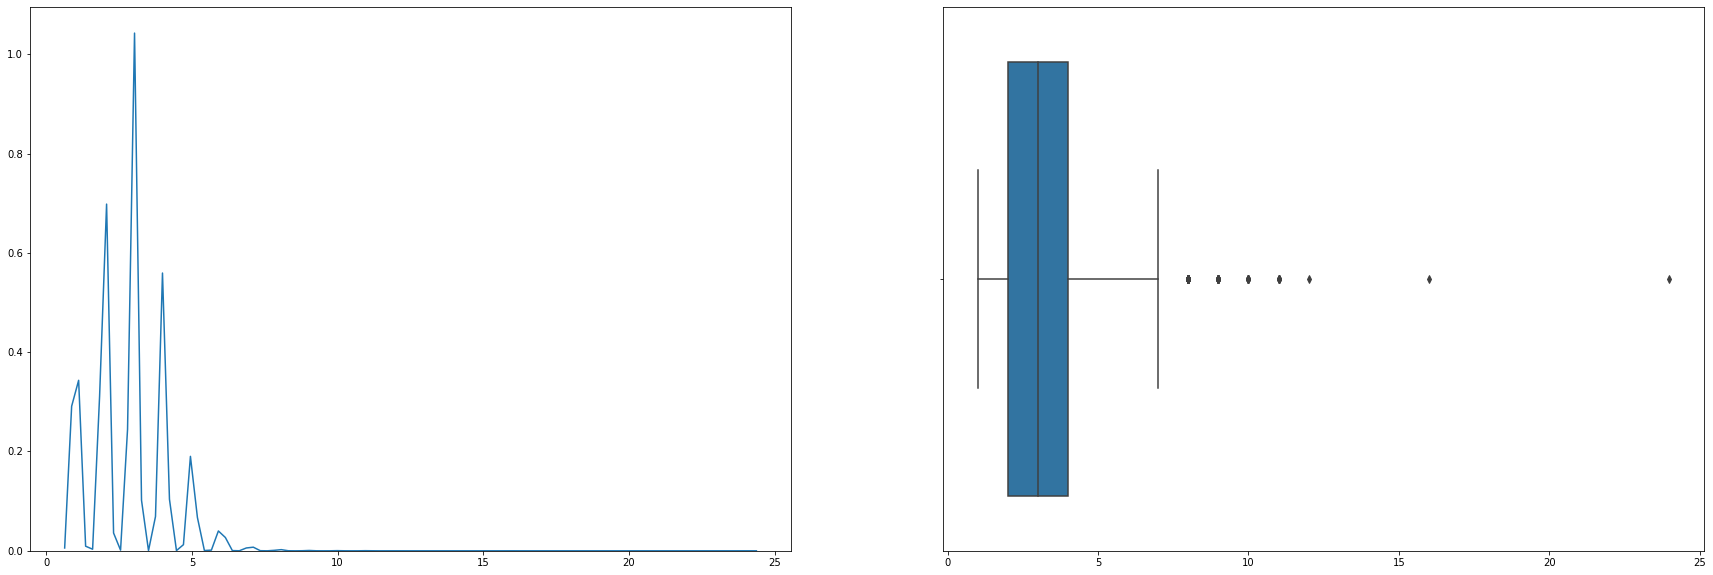

In [63]:
import seaborn as sns

f, axes = plt.subplots(1, 2)
sns.kdeplot(df_count, ax=axes[0])
sns.boxplot(df_count, ax=axes[1])
plt.show()

A we can see, most texts in our dataset have from 1 to 5 labels, peaking at 3. We could leverage that observation to create better models.

Our model of logistic regression gives us probability values and classifies texts using a threshold. If the threshold is **low**, we get too many texts with **more than 5 labels**. If the threshold is **high**, we get a lot of texts with **0 labels**.

What if we assigned labels based on the threshold and if we get less than `min_labels` labels, we get `min_labels` labels with highest probabilities. Similarily, if we get more than `max_labels` labels, we could get `max_labels` labels with highest probabilities. We suspect that this technique will result in higher scores than just assigning `default_labels` if we get 0 labels.

Let's check it.

In [37]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].apply(stem)
df_train, df_test = train_test_split(df, random_state=42, test_size=0.25, shuffle=True)

In [38]:
def get_proba_logistic(df_train, df_test, labels, C=1.0, n_jobs=-1):
    pipeline = get_logistic_pipeline(C=C, n_jobs=n_jobs)
    predictions = pd.DataFrame(df_test['name'])

    for i, category in enumerate(labels):
        pipeline.fit(df_train['text'], df_train[category])
        pred = pipeline.predict_proba(df_test['text'])[:, 1]
        predictions = predictions.assign(**{category: pred})
    return predictions


def get_preds_from_proba(predictions, threshold=0.1, min_labels=2, max_labels=6):
    pred = predictions.copy()
    
    how_many = (pred.iloc[:, 1:] >= threshold).sum(axis=1)
    ranked = pred.iloc[:, 1:].rank(axis=1, ascending=False)
    
    for i, row in pred.iterrows():
        if min_labels <= how_many.loc[i] <= max_labels:
            pred.at[i, 1:] = (row[1:] >= threshold)
        else:
            if how_many[i] > max_labels:
                pred.at[i, 1:] = (ranked.loc[i, :] < (max_labels + 1))
            else: # how_many[i] < min_labels:
                pred.at[i, 1:] = (ranked.loc[i, :] < (min_labels + 1))
    
    pred = pred.drop('name', axis=1)
    pred = pred.astype(int)
    return pred

In [39]:
proba_logistic = get_proba_logistic(df_train, df_test, labels, C=1.0)

In [40]:
for min_labels in range(1, 4):
    for max_labels in range(min_labels, 5):
        pred_with_bounds = get_preds_from_proba(proba_logistic, threshold=0.15, min_labels=min_labels, max_labels=max_labels)
        print(f'Results for min_labels={min_labels}, max_labels={max_labels}:')
        print_scores(pred_with_bounds, df_test, labels)
        print('')

Results for min_labels=1, max_labels=1:
F1 score: 0.3362643838383838
Precision: 0.60796
Recall: 0.2505395743145743

Results for min_labels=1, max_labels=2:
F1 score: 0.40227117349317354
Precision: 0.52306
Recall: 0.3638941298701299

Results for min_labels=1, max_labels=3:
F1 score: 0.4173662346542347
Precision: 0.48306
Recall: 0.4242084155844156

Results for min_labels=1, max_labels=4:
F1 score: 0.4185505692085692
Precision: 0.46371
Recall: 0.4544254011544011

Results for min_labels=2, max_labels=2:
F1 score: 0.40918571317571323
Precision: 0.49212
Recall: 0.386564606060606

Results for min_labels=2, max_labels=3:
F1 score: 0.42428077433677436
Precision: 0.45212
Recall: 0.44687889177489176

Results for min_labels=2, max_labels=4:
F1 score: 0.4254651088911089
Precision: 0.43277
Recall: 0.47709587734487735

Results for min_labels=3, max_labels=3:
F1 score: 0.422604148962149
Precision: 0.41745333333333334
Recall: 0.4784620822510822

Results for min_labels=3, max_labels=4:
F1 score: 0.42378

As we can see, we got quite good result (0.4255) for bounds [2, 4].

In [43]:
pred_logistic_with_bounds = get_preds_from_proba(proba_logistic, threshold=0.15, min_labels=2, max_labels=4)
print_scores(pred_logistic_with_bounds, df_test, labels)

F1 score: 0.4254651088911089
Precision: 0.43277
Recall: 0.47709587734487735


We can try to merge those results with results from SVC. We know that SVC gave us high precision, so we hope that the increase from recall will exceed the loss of precision.

In [45]:
pred_combined = combine_predictions([pred_logistic_with_bounds, pred_svc_c_1], labels)
print_scores(pred_combined, df_test, labels)

F1 score: 0.42648932067932066
Precision: 0.4316039047619048
Recall: 0.48085454401154404


As we predicted, precision is slightly lower, recall is slightly higher, but the F1 score is higher.

## Challange data

Let's combine our techniques to create a submission.

In [46]:
import numpy as np


def load_test_data(filepath):
    with open(filepath, 'rb') as f:
        decoded_lines = (line.decode(encoding='iso_8859_1') for line in f)

        parsed_lines = csv.reader(decoded_lines, dialect="excel-tab")

        names = []
        texts = []
    
        for name, text, _ in parsed_lines:
            names.append(name)
            texts.append(text)

    return pd.DataFrame({'name': names, 'text': texts})


def write_prediction(predictions, filepath):
    with open(filepath, 'w') as f:
        for i, (_, row) in enumerate(predictions.iterrows()):
            pred_labels = []
            for label in labels:
                if row[label] == 1:
                    pred_labels.append(label)
            
            f.write(','.join(pred_labels) + '\n')

In [55]:
df = load_training_data('data/DM2020_training_docs_and_labels.txt')
df_challenge = load_test_data('data/DM2020_test_docs.txt')

df['text'] = df['text'].apply(clean_text)
df_challenge['text'] = df_challenge['text'].apply(clean_text)

df['text'] = df['text'].apply(stem)
df_challenge['text'] = df_challenge['text'].apply(stem)

In [56]:
challenge_svc = fit_and_predict(get_svm_pipeline(C=1.0), df, df_challenge, labels)

In [57]:
challenge_proba_logistic = get_proba_logistic(df, df_challenge, labels, C=1.0)

In [58]:
challenge_logistic = get_preds_from_proba(challenge_proba_logistic, threshold=0.13, min_labels=2, max_labels=4)

In [59]:
challenge_combined = combine_predictions([challenge_logistic, challenge_svc], labels)
write_prediction(challenge_combined, 'results/challenge_t013_b2-4.txt')

Our score is `0.4296`!

*Author: Jakub Godula*